<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  --

<ipython-input-3-a0250b9050bd>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 7156 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             7156 non-null   object 
 1   Category        7156 non-null   object 
 2   Type            7156 non-null   object 
 3   Content Rating  7156 non-null   object 
 4   Genres          7156 non-null   object 
 5   Last Updated    7156 non-null   object 
 6   Current Ver     7156 non-null   object 
 7   Android Ver     7156 non-null   object 
 8   Size            7156 non-null   float64
 9   Installs        7156 non-null   float64
 10  Price           7156 non-null   float64
 11  Reviews         7156 non-null   float64
 12  Rating          7156 non-null   float64
dtypes: float64(5), object(8)
memory usage: 782.7+ KB


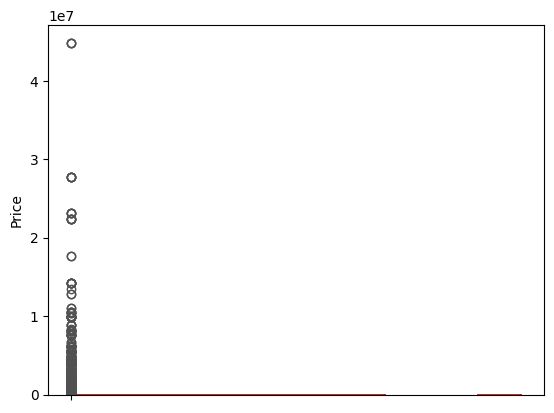

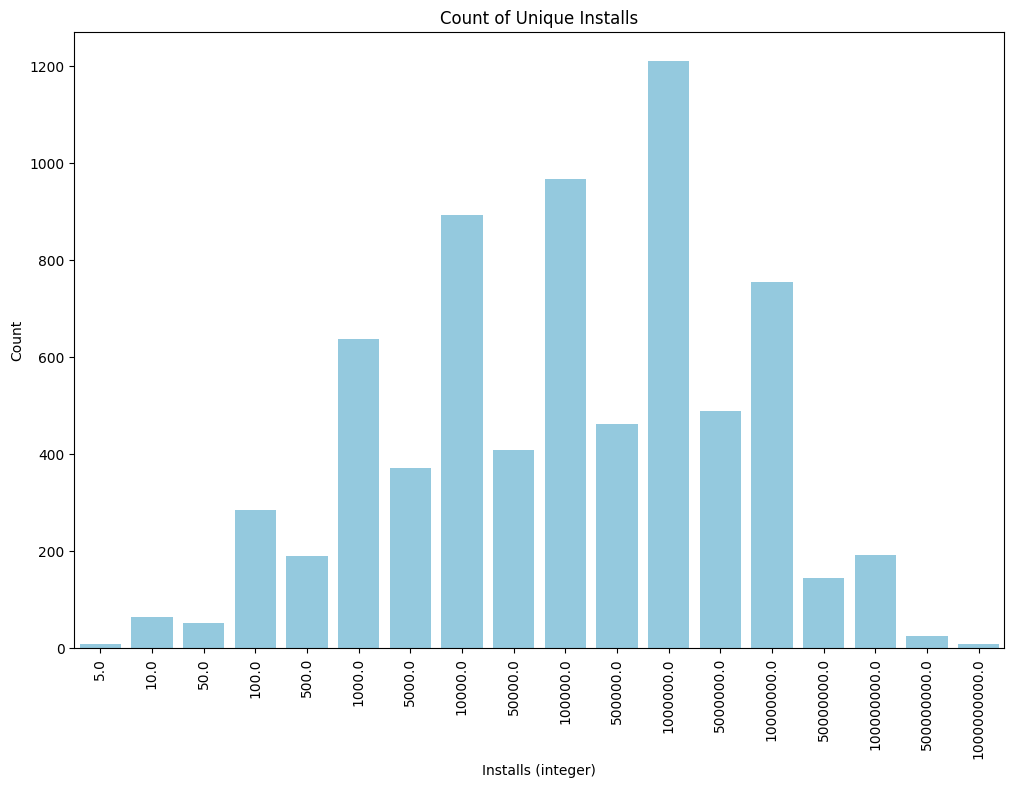

<ipython-input-3-a0250b9050bd>:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_cleaned['Reviews']/df_cleaned['Installs']*100, palette="Set3")


Model Coefficients:
[-4.33374186e-05  1.50283964e-08 -7.63831041e-04 -1.34011261e-07
  1.76318789e-01 -1.59168724e-01 -3.29059032e-01  3.96468940e-03
  1.22136681e-01  7.36493818e-02 -1.22167441e-02  2.37287393e-01
 -9.25080858e-02 -1.28407369e-01  1.32834735e-02 -1.51894764e-02
  1.68628645e-01  1.12769334e-02 -7.37128761e-02 -3.11936931e-02
  1.70451580e-01 -1.89427050e-02 -1.14005557e-02  1.24416217e-01
 -1.40732815e-01 -7.36861057e-02  2.31539443e-02 -1.34270648e-02
  1.91940504e-01  5.41811428e-02 -6.77194030e-02 -1.06048102e-02
 -2.54803560e-02 -1.13988823e-02 -5.51912062e-02 -8.48804909e-02
 -2.14608994e-02  1.12740199e-02  1.15679634e-02 -2.76683958e-01
 -2.05665162e-02 -3.33343411e-01 -8.19152264e-02 -3.95691535e-11
 -3.73853960e-01 -2.58542895e-01 -2.03290075e-03  2.00287869e-01
  6.00377512e-01  3.07237593e-01  2.24287277e-01  3.96468951e-03
  1.22136681e-01 -2.03184945e-01 -1.72130522e-01  9.19082683e-02
 -6.05016037e-11  7.36493815e-02  4.47003725e-01 -1.22167447e-02
 -3.7

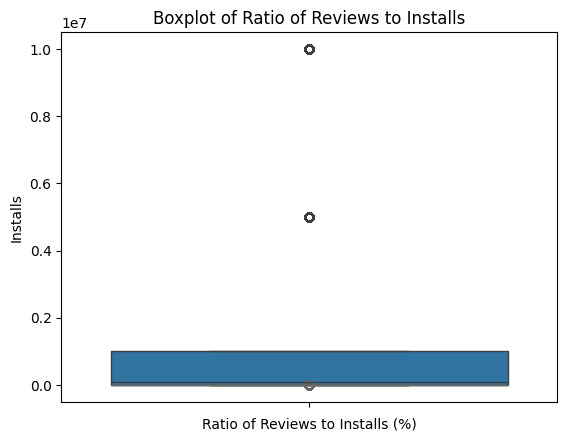

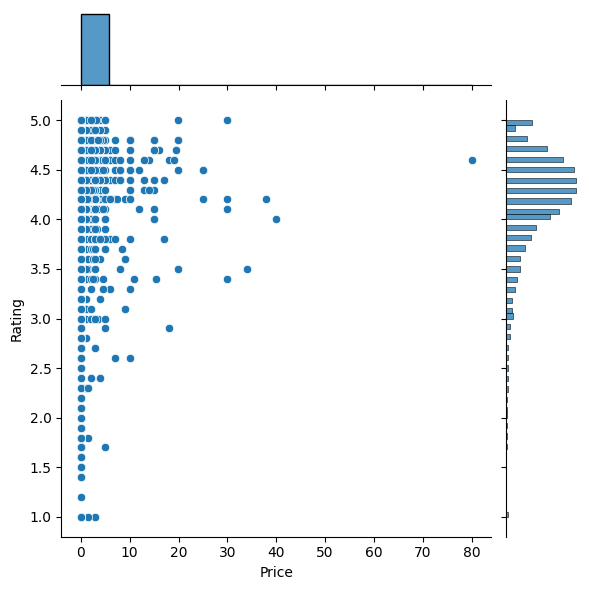

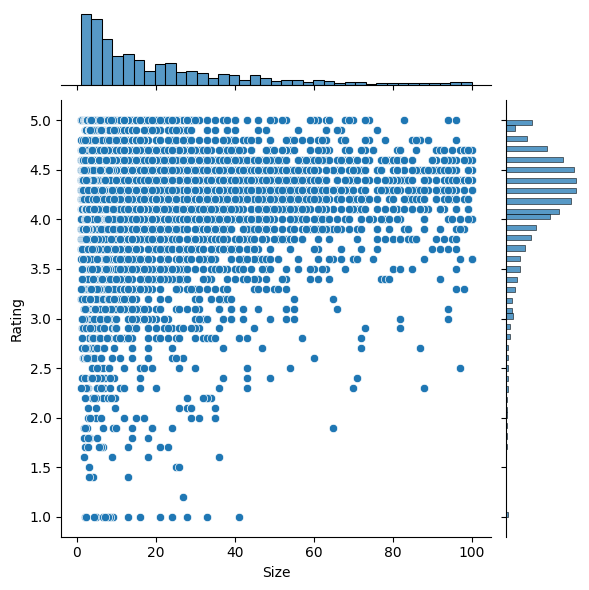

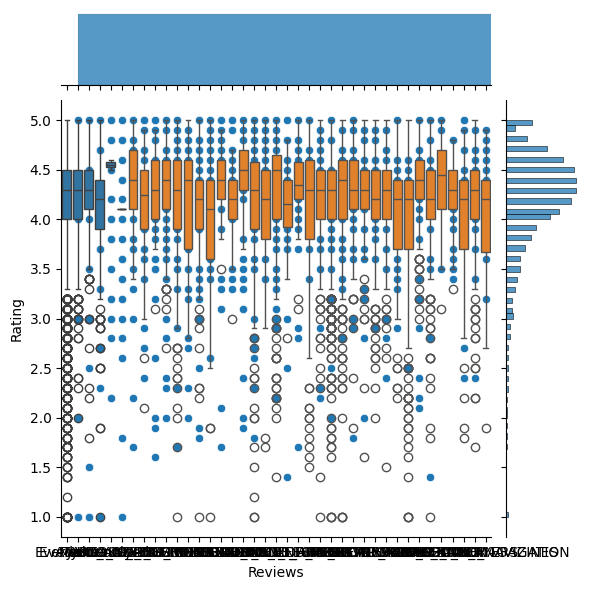

In [3]:
# App Rating Prediction

## Dataset
# App: Application name
# Category: Category of the app
# Rating: Overall user rating of the app (target variable)
# Reviews: Number of user reviews
# Size: Size of the app
# Installs: Number of user downloads/installs
# Type: Paid or Free
# Price: Price of the app
# Content Rating: Age group the app is targeted at (Children, Mature 21+, Adult)
# Genres: Additional genres the app belongs to
# Last Updated: Date when the app was last updated
# Current Ver: Current version of the app
# Android Ver: Minimum required Android version


## Coding
# connecting, uploading data, uploading or creating a new notebook,
# importing liabraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reading the data
df = pd.read_csv('abcplaystore.csv')
df.head(30)

#Data profiling
# Checking and standardizing data types
# View data format
df.info()

# Standardizing data format
# Define the function
def convert_Size(Size_str):
    if pd.isna(Size_str):
        return None
    Size_str = Size_str.replace(',', '')  # Remove commas
    if any(char in Size_str for char in ['K', 'M', '+']):
        return float(Size_str.replace('K', '').replace('M', '').replace('+', ''))
    elif Size_str.isdigit():
        return float(Size_str)
    else:
        return None
# Apply convert_Size function to Size column
df['Size_numeric'] = df['Size'].apply(convert_Size)

def convert_Installs(Installs_str):
    if pd.isna(Installs_str):  # Check if the value is NaN
        return None
    Installs_str = Installs_str.replace(',', '')  # Remove commas
    if '+' in Installs_str:  # Check if there's a plus sign
        return float(Installs_str.replace('+', ''))
    elif Installs_str.isdigit():  # Check if the string is a digit (after comma removal)
        return float(Installs_str)
    else:  # If neither condition matches, return None
        return None

df['Installs_numeric'] = df['Installs'].apply(convert_Installs)

def convert_Price(Price_str):
    if pd.isna(Price_str):
        return None
    Price_str = Price_str.replace(',', '')  # Remove commas
    if '$' in Price_str:
        return float(Price_str.replace('$', ''))
    elif Price_str.isdigit():
        return float(Price_str)
    else:
        return None
df['Price_numeric'] = df['Price'].apply(convert_Price)

df['Reviews_numeric'] = pd.to_numeric(df['Reviews'], errors='coerce')

df.info()

# Data cleaning
# Remove rows with missing values, if too many are deleted, it indicates some numbers are 0 and were missed
df.shape

df.isnull().sum()/df.shape[0]*100
df_cleaned = df.dropna()
df_cleaned.isnull().sum()

df_cleaned.shape

# Remove duplicate rows
# Count duplicate rows
df_cleaned.duplicated().sum()
# Print and view duplicate rows
identical_rows = df[df.duplicated(keep=False)]
# Sort and print duplicate rows
identical_rows_sorted = identical_rows.sort_values(by=list(df.columns))
print(identical_rows_sorted)
# Remove duplicate rows
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.shape

# Remove logically incorrect rows
df_cleaned = df_cleaned[(df_cleaned['Rating'] >= 1) & (df_cleaned['Rating'] <= 5)]
df_cleaned = df_cleaned[df_cleaned['Reviews_numeric'] <= df_cleaned['Installs_numeric']]
df_cleaned = df_cleaned[~((df_cleaned['Type'] == 'Free') & (df_cleaned['Price_numeric'] > 0))]
df_cleaned.shape

# Rename and save new table
# Drop the old columns
df_cleaned = df_cleaned.drop(columns=['Price', 'Size', 'Installs', 'Reviews'])

# Rename the new columns to the original names
df_cleaned = df_cleaned.rename(columns={
    'Price_numeric': 'Price',
    'Size_numeric': 'Size',
    'Installs_numeric': 'Installs',
    'Reviews_numeric': 'Reviews'  # Corrected colon issue here
})

# Adjust column order, group numeric columns together
rating_col = df_cleaned.pop('Rating')  # Remove 'Rating' column and save it
df_cleaned['Rating'] = rating_col      # Re-add it at the end

df_cleaned.to_excel('df_cleaned.xlsx')

#make sure the data is properly cleaneddf_cleaned.head()
df_cleaned.head()
df_cleaned.info()
df_cleaned.describe()
df_cleaned.isnull().sum()

# Univariate analysis, removing outliers — actually, it's clearer in Tableau

# Using boxplot and histograms to check for outliers
plt.hist(df_cleaned['Rating'])

plt.hist(df_cleaned['Size'])

sns.boxplot(df_cleaned['Price'])
plt.hist(df_cleaned['Price'])

sns.boxplot(df_cleaned['Reviews'])
plt.hist(df_cleaned['Reviews'])

da = df_cleaned['Installs'].value_counts()
da = da.sort_index()
da

da.index = da.index.astype(str)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=da.index, y=da.values, color='skyblue')
plt.xlabel('Installs (integer)')
plt.ylabel('Count')
plt.title('Count of Unique Installs')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

import numpy as np

percentiles = np.percentile(df_cleaned['Installs'], [10, 25, 50, 70, 90, 95, 99])
percentiles

# Based on the analysis (Tableau), decide which outliers to remove
df_cleaned = df_cleaned.drop(df_cleaned[df_cleaned['Price'] > 200].index)
df_cleaned = df_cleaned.drop(df_cleaned[df_cleaned['Reviews'] > 2000000].index)
df_cleaned = df_cleaned.drop(df_cleaned[df_cleaned['Installs'] >= 5.e+07].index)

sns.boxplot(df_cleaned['Installs'])

# Bivariate relationship analysis - Python seems better
sns.boxplot(df_cleaned['Reviews']/df_cleaned['Installs']*100, palette="Set3")
plt.xlabel('Ratio of Reviews to Installs (%)')
plt.title('Boxplot of Ratio of Reviews to Installs')

# Scatter plot between numeric variables - checking for positive or negative correlation
sns.jointplot(x=df_cleaned['Price'], y=df_cleaned['Rating'], kind='scatter')
sns.jointplot(x=df_cleaned['Size'], y=df_cleaned['Rating'], kind='scatter')
sns.jointplot(x=df_cleaned['Reviews'], y=df_cleaned['Rating'], kind='scatter')

# Boxplot between categorical and numeric variables - checking for significant differences
sns.boxplot(x=df_cleaned['Content Rating'], y=df_cleaned['Rating'])
sns.boxplot(x=df_cleaned['Category'], y=df_cleaned['Rating'])

inp1 = df_cleaned
inp1.shape

# Change 'Review' to 'Reviews' to access the correct column
inp1['Reviews_log'] = np.log1p(inp1['Reviews'])
inp1['Installs_log'] = np.log1p(inp1['Installs'])

inp1.drop(['App','Last Updated','Current Ver','Android Ver'], axis=1, inplace=True)

inp1.shape

inp1 = pd.get_dummies(inp1, columns=['Category', 'Genres', 'Content Rating'])

inp1 = pd.get_dummies(inp1, columns=['Type'])

inp1

# Regression
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(inp1, test_size=0.3, random_state=42)

# Features
X_train = df_train.drop('Rating', axis=1)
X_test = df_test.drop('Rating', axis=1)

# Target variable
y_train = df_train['Rating']
y_test = df_test['Rating']

from sklearn import linear_model

# Initialize linear regression model
model = linear_model.LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Print model coefficients
print("Model Coefficients:")
print(model.coef_)

from sklearn.metrics import r2_score
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R2 score on the training set: {r2_train}")

comparison_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train})

# Print comparison results and R2 score on the training set
print("Training set prediction comparison:")
print(comparison_df)
print("\nR2 score on the training set:", r2_train)
